# **Connect to Google Drive**

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


# **Import library**

In [ ]:
import os
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.models import Model, Input
from tensorflow.keras.optimizers import Adam

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# **Data overview**

In [ ]:
path_csv = '/content/drive/MyDrive/Colab/NhapMonThiGiacMayTinh/MushroomClassification/data/data/mushroom_dataset.csv'
df = pd.read_csv(path_csv)

In [ ]:
df['Label'] = df['Label'].apply(lambda x: 'POISONOUS' if x != 'EDIBLE' else x)
df['Label'].value_counts()

EDIBLE       3477
POISONOUS    2909
Name: Label, dtype: int64

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

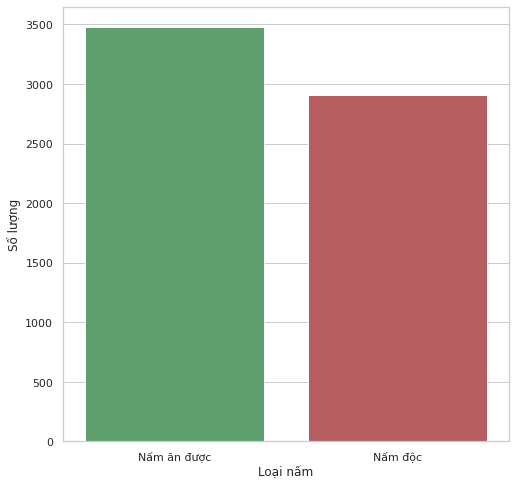

In [ ]:
sns.set(style="whitegrid", color_codes=True)
class_names = ['Edible', 'Poisonous']
plt.figure(figsize=(8, 8))
ax = sns.countplot(x='Label', data=df, palette=['g', 'r'])
ax.set(xlabel='Loại nấm', ylabel='Số lượng')
ax.set_xticklabels(["Nấm ăn được","Nấm độc"])
plt.xticks(rotation=0)

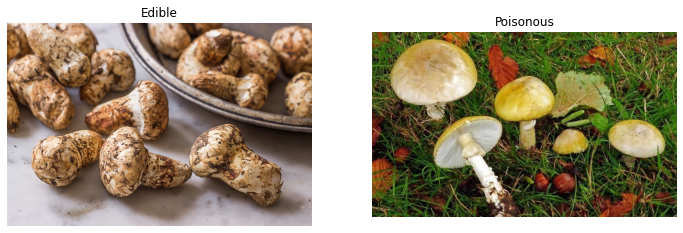

In [ ]:
nrows = 1
ncols = 2
position = 0

data_path = '/content/drive/MyDrive/Colab/NhapMonThiGiacMayTinh/MushroomClassification/data/data_splited_general/test'

for subfolder in os.listdir(data_path):
    image_file = os.listdir(os.path.join(data_path, subfolder))[0]

    fig = plt.gcf()
    fig.set_size_inches(ncols * 6, nrows * 6)
    position += 1
    sp = plt.subplot(nrows, ncols, position)
    cur_image = mpimg.imread(os.path.join(data_path, subfolder, image_file))
    plt.imshow(cur_image)
    plt.title(subfolder.replace('POISONOUS_', '').replace('_', ' ').lower().title())
    plt.axis('Off')

# **Load data**

In [ ]:
IMG_SIZE = 227
BATCH_SIZE = 128
IMG_CHANNEL = 3

In [ ]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator.flow_from_directory(directory='/content/drive/MyDrive/Colab/NhapMonThiGiacMayTinh/MushroomClassification/data/data_splited_general/train',
                                                     target_size=(IMG_SIZE, IMG_SIZE),
                                                     class_mode='binary',
                                                     batch_size=BATCH_SIZE,
                                                     color_mode='rgb',
                                                     shuffle=True)

dev_generator = data_generator.flow_from_directory(directory='/content/drive/MyDrive/Colab/NhapMonThiGiacMayTinh/MushroomClassification/data/data_splited_general/dev',
                                                   target_size=(IMG_SIZE, IMG_SIZE),
                                                   class_mode='binary',
                                                   batch_size=BATCH_SIZE,
                                                   color_mode='rgb',
                                                   shuffle=True)
                    
test_generator = data_generator.flow_from_directory(directory='/content/drive/MyDrive/Colab/NhapMonThiGiacMayTinh/MushroomClassification/data/data_splited_general/test',
                                                    target_size=(IMG_SIZE, IMG_SIZE),
                                                    class_mode='binary',
                                                    color_mode='rgb',
                                                    shuffle=True)

Found 4589 images belonging to 2 classes.
Found 515 images belonging to 2 classes.
Found 1282 images belonging to 2 classes.


In [ ]:
class_dictionary = test_generator.class_indices
class_names = list(class_dictionary.keys())
class_names = [i.lower().title() for i in class_names]

# **Model**

In [ ]:
def show_accuracy_loss(history):
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(20, 6))
    for i, item in enumerate(['accuracy', 'loss']):
        ax = fig.add_subplot(1, 2, i+1)
        ax = plt.plot(history.history[item])
        ax = plt.plot(history.history['val_'+item])
        plt.title('model '+item)
        plt.ylabel(item)
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')

## **VGG16**

### **Training**

In [ ]:
vgg = VGG16(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, IMG_CHANNEL))

for layer in vgg.layers:
    layer.trainable = False

flat = Flatten()(vgg.layers[-1].output)
batch = BatchNormalization()(flat)
dense = Dense(256, activation='relu')(batch)
dropout = Dropout(0.5)(dense)
batch = BatchNormalization()(dropout)
dense = Dense(128, activation='relu')(batch)
dropout = Dropout(0.5)(dense)
batch = BatchNormalization()(dropout)
dense = Dense(64, activation='relu')(batch)
dropout = Dropout(0.5)(dense)
batch = BatchNormalization()(dropout)
output = Dense(1, activation='sigmoid')(batch)

model = Model(inputs=vgg.inputs, outputs=output)

optimizer = Adam(learning_rate=5e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                              

In [ ]:
history = model.fit(train_generator,
                    validation_data=dev_generator,
                    epochs=40)

Epoch 1/40
36/36 [==============================] - 729s 19s/step - loss: 0.6803 - accuracy: 0.6343 - val_loss: 0.8258 - val_accuracy: 0.7126
Epoch 2/40
36/36 [==============================] - 137s 4s/step - loss: 0.5338 - accuracy: 0.7254 - val_loss: 0.5475 - val_accuracy: 0.7670
Epoch 3/40
36/36 [==============================] - 137s 4s/step - loss: 0.4240 - accuracy: 0.8106 - val_loss: 0.4557 - val_accuracy: 0.7961
Epoch 4/40
36/36 [==============================] - 137s 4s/step - loss: 0.3283 - accuracy: 0.8616 - val_loss: 0.4407 - val_accuracy: 0.8194
Epoch 5/40
36/36 [==============================] - 136s 4s/step - loss: 0.2447 - accuracy: 0.9070 - val_loss: 0.4491 - val_accuracy: 0.8136
Epoch 6/40
36/36 [==============================] - 136s 4s/step - loss: 0.1769 - accuracy: 0.9416 - val_loss: 0.4952 - val_accuracy: 0.8019
Epoch 7/40
36/36 [==============================] - 136s 4s/step - loss: 0.1340 - accuracy: 0.9614 - val_loss: 0.5174 - val_accuracy: 0.8019
Epoch 8/40
3

### **Save and load**

In [ ]:
path_model = '/content/drive/MyDrive/Colab/NhapMonThiGiacMayTinh/MushroomClassification/data/data_splited_general/vgg16.h5'

In [ ]:
model.save(path_model, save_format='h5')

In [ ]:
model = keras.models.load_model(path_model)

In [ ]:
from keras.preprocessing import image
import numpy as np

path_img = '/content/drive/MyDrive/Colab/NhapMonThiGiacMayTinh/MushroomClassification/data/data_splited_general/test/POISONOUS/113_POISONOUS_PLEUROCYBELLA_PORRIGENS.jpg'
test = image.load_img(path_img, target_size=(227, 227, 3))

x = image.img_to_array(test)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

result = model.predict(x)[0]
result

array([0.97621673], dtype=float32)

In [ ]:
prob = result[0]
prob

0.97621673

In [ ]:
y_pred = 1 if result[0] > 0.5 else 0
y_pred

1

### **Evaluate**

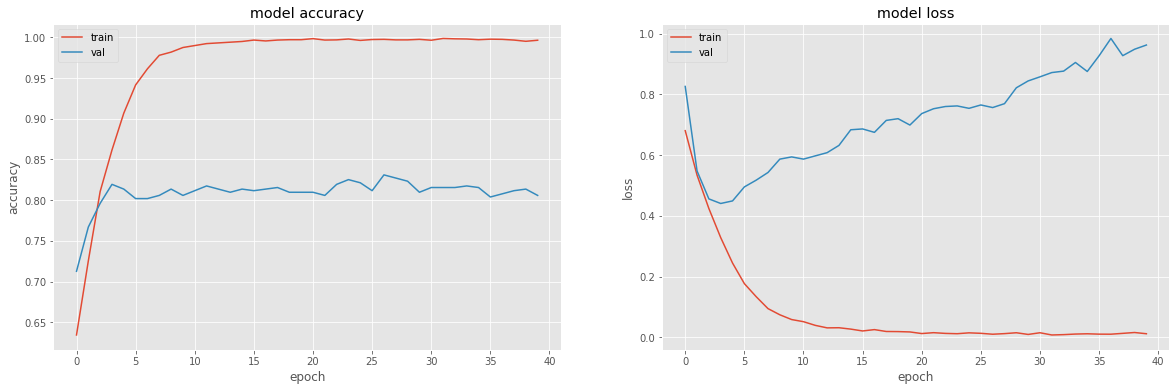

In [ ]:
show_accuracy_loss(history)

In [ ]:
y_pred_total = []
y_true = []

for idx, (img, label) in enumerate(test_generator):
    if idx == len(test_generator):
        break
    y_pred = model.predict(img)
    y_pred_total += [1 if i > 0.5 else 0 for i in y_pred]
    y_true += np.array(label).flatten().tolist()

In [ ]:
print("Accuracy: {:.4f}".format(accuracy_score(y_true, y_pred_total)))
print("Precision - micro: {:.4f}".format(precision_score(y_true, y_pred_total, average='micro')))
print("Precision - macro: {:.4f}".format(precision_score(y_true, y_pred_total, average='macro')))
print("Recall - micro: {:.4f}".format(recall_score(y_true, y_pred_total, average='micro')))
print("Recall - macro: {:.4f}".format(recall_score(y_true, y_pred_total, average='macro')))
print("F1 - micro: {:.4f}".format(f1_score(y_true, y_pred_total, average='micro')))
print("F1 - macro: {:.4f}".format(f1_score(y_true, y_pred_total, average='macro')))

Accuracy: 0.8190
Precision - micro: 0.8190
Precision - macro: 0.8191
Recall - micro: 0.8190
Recall - macro: 0.8155
F1 - micro: 0.8190
F1 - macro: 0.8168


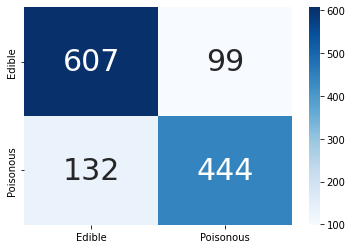

In [ ]:
cf = confusion_matrix(y_true, y_pred_total)
df_cm = pd.DataFrame(cf, index = class_names, columns = class_names)
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g', cbar=True, annot_kws={"size": 30})

In [ ]:
print(classification_report(y_true, y_pred_total, target_names=class_names))

              precision    recall  f1-score   support

      Edible       0.82      0.86      0.84       706
   Poisonous       0.82      0.77      0.79       576

    accuracy                           0.82      1282
   macro avg       0.82      0.82      0.82      1282
weighted avg       0.82      0.82      0.82      1282



## **Resnet50**

### **Training**

In [ ]:
resnet = ResNet50(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, IMG_CHANNEL))

for layer in resnet.layers:
    layer.trainable = False

flat = Flatten()(resnet.layers[-1].output)
batch = BatchNormalization()(flat)
dense = Dense(256, activation='relu')(batch)
dropout = Dropout(0.5)(dense)
batch = BatchNormalization()(dropout)
dense = Dense(128, activation='relu')(batch)
dropout = Dropout(0.5)(dense)
batch = BatchNormalization()(dropout)
dense = Dense(64, activation='relu')(batch)
dropout = Dropout(0.5)(dense)
batch = BatchNormalization()(dropout)
output = Dense(1, activation='sigmoid')(batch)

model = Model(inputs=resnet.inputs, outputs=output)
optimizer = Adam(learning_rate=5e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 233, 233, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 114, 114, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [ ]:
history = model.fit(train_generator,
                    validation_data=dev_generator,
                    epochs=40)

Epoch 1/40
36/36 [==============================] - 153s 4s/step - loss: 0.6569 - accuracy: 0.6548 - val_loss: 1.1119 - val_accuracy: 0.7126
Epoch 2/40
36/36 [==============================] - 140s 4s/step - loss: 0.5059 - accuracy: 0.7592 - val_loss: 0.4865 - val_accuracy: 0.7903
Epoch 3/40
36/36 [==============================] - 139s 4s/step - loss: 0.3944 - accuracy: 0.8220 - val_loss: 0.4105 - val_accuracy: 0.8214
Epoch 4/40
36/36 [==============================] - 139s 4s/step - loss: 0.2888 - accuracy: 0.8895 - val_loss: 0.3901 - val_accuracy: 0.8311
Epoch 5/40
36/36 [==============================] - 139s 4s/step - loss: 0.2121 - accuracy: 0.9270 - val_loss: 0.4126 - val_accuracy: 0.8194
Epoch 6/40
36/36 [==============================] - 138s 4s/step - loss: 0.1473 - accuracy: 0.9569 - val_loss: 0.4516 - val_accuracy: 0.8078
Epoch 7/40
36/36 [==============================] - 138s 4s/step - loss: 0.1140 - accuracy: 0.9667 - val_loss: 0.4949 - val_accuracy: 0.7864
Epoch 8/40
36

### **Save and load**

In [ ]:
path_model = '/content/drive/MyDrive/Colab/NhapMonThiGiacMayTinh/MushroomClassification/data/data_splited_general/resnet50.h5'

In [ ]:
model.save(path_model, save_format='h5')

In [ ]:
model = keras.models.load_model(path_model)

### **Evaluate**

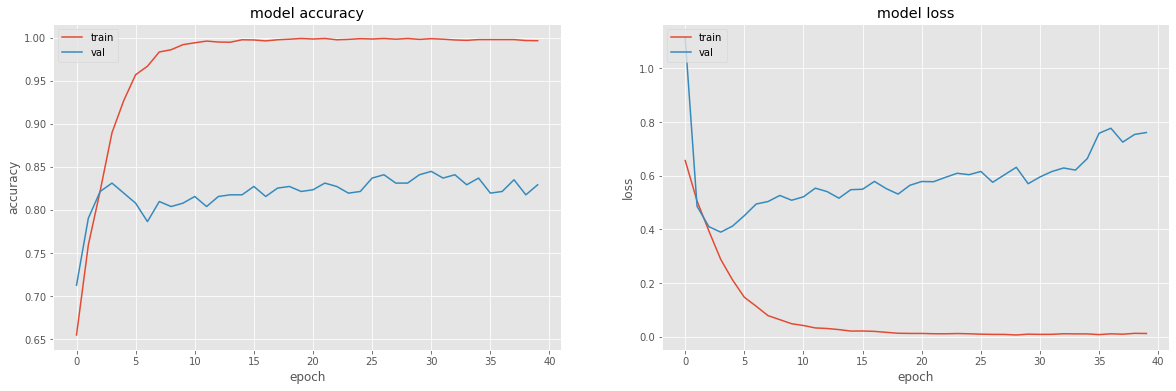

In [ ]:
show_accuracy_loss(history)

In [ ]:
y_pred_total = []
y_true = []

for idx, (img, label) in enumerate(test_generator):
    if idx == len(test_generator):
        break
    y_pred = model.predict(img)
    y_pred_total += [1 if i > 0.5 else 0 for i in y_pred]
    y_true += np.array(label).flatten().tolist()

In [ ]:
print("Accuracy: {:.4f}".format(accuracy_score(y_true, y_pred_total)))
print("Precision - micro: {:.4f}".format(precision_score(y_true, y_pred_total, average='micro')))
print("Precision - macro: {:.4f}".format(precision_score(y_true, y_pred_total, average='macro')))
print("Recall - micro: {:.4f}".format(recall_score(y_true, y_pred_total, average='micro')))
print("Recall - macro: {:.4f}".format(recall_score(y_true, y_pred_total, average='macro')))
print("F1 - micro: {:.4f}".format(f1_score(y_true, y_pred_total, average='micro')))
print("F1 - macro: {:.4f}".format(f1_score(y_true, y_pred_total, average='macro')))

Accuracy: 0.8354
Precision - micro: 0.8354
Precision - macro: 0.8380
Recall - micro: 0.8354
Recall - macro: 0.8306
F1 - micro: 0.8354
F1 - macro: 0.8327


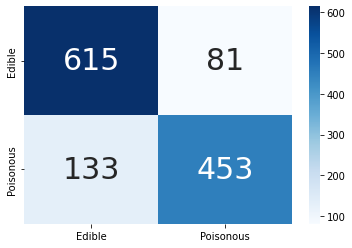

In [ ]:
cf = confusion_matrix(y_true, y_pred_total)
df_cm = pd.DataFrame(cf, index = class_names, columns = class_names)
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g', cbar=True, annot_kws={"size": 30})

In [ ]:
print(classification_report(y_true, y_pred_total, target_names=class_names))

              precision    recall  f1-score   support

      Edible       0.82      0.88      0.85       696
   Poisonous       0.85      0.77      0.81       586

    accuracy                           0.83      1282
   macro avg       0.84      0.83      0.83      1282
weighted avg       0.83      0.83      0.83      1282



## **EfficientNet**

### **Training**

In [ ]:
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

model.trainable = False

x = GlobalAveragePooling2D(name="avg_pool")(model.output)
x = BatchNormalization()(x)

top_dropout_rate = 0.2
x = Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = Dense(1, activation="sigmoid", name="pred")(x)

model = Model(inputs, outputs, name="EfficientNet")

optimizer = Adam(learning_rate=5e-4)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 227, 227, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 227, 227, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 229, 229, 3)  0           ['normalization[0][0]'

In [ ]:
history = model.fit(train_generator,
                    validation_data=dev_generator,
                    epochs=40)

Epoch 1/40
36/36 [==============================] - 559s 15s/step - loss: 0.6804 - accuracy: 0.6529 - val_loss: 0.5636 - val_accuracy: 0.7223
Epoch 2/40
36/36 [==============================] - 131s 4s/step - loss: 0.5134 - accuracy: 0.7605 - val_loss: 0.5148 - val_accuracy: 0.7495
Epoch 3/40
36/36 [==============================] - 130s 4s/step - loss: 0.4552 - accuracy: 0.7997 - val_loss: 0.4740 - val_accuracy: 0.7903
Epoch 4/40
36/36 [==============================] - 131s 4s/step - loss: 0.4164 - accuracy: 0.8128 - val_loss: 0.4283 - val_accuracy: 0.8214
Epoch 5/40
36/36 [==============================] - 131s 4s/step - loss: 0.3895 - accuracy: 0.8274 - val_loss: 0.4036 - val_accuracy: 0.8330
Epoch 6/40
36/36 [==============================] - 129s 4s/step - loss: 0.3656 - accuracy: 0.8403 - val_loss: 0.3838 - val_accuracy: 0.8388
Epoch 7/40
36/36 [==============================] - 130s 4s/step - loss: 0.3550 - accuracy: 0.8472 - val_loss: 0.3595 - val_accuracy: 0.8602
Epoch 8/40
3

### **Save and load**

In [ ]:
path_model = '/content/drive/MyDrive/Colab/NhapMonThiGiacMayTinh/MushroomClassification/data/data_splited_general/efficientnet_b0.h5'

In [ ]:
model.save(path_model, save_format='h5')

In [ ]:
model = keras.models.load_model(path_model)

### **Evaluate**

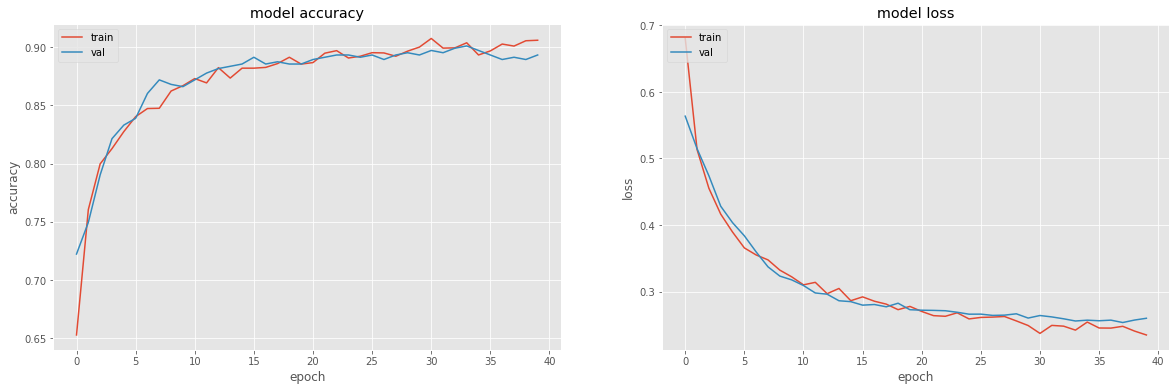

In [ ]:
show_accuracy_loss(history)

In [ ]:
y_pred_total = []
y_true = []

for idx, (img, label) in enumerate(test_generator):
    if idx == len(test_generator):
        break
    y_pred = model.predict(img)
    y_pred_total += [1 if i > 0.5 else 0 for i in y_pred]
    y_true += np.array(label).flatten().tolist()

In [ ]:
print("Accuracy: {:.4f}".format(accuracy_score(y_true, y_pred_total)))
print("Precision - micro: {:.4f}".format(precision_score(y_true, y_pred_total, average='micro')))
print("Precision - macro: {:.4f}".format(precision_score(y_true, y_pred_total, average='macro')))
print("Recall - micro: {:.4f}".format(recall_score(y_true, y_pred_total, average='micro')))
print("Recall - macro: {:.4f}".format(recall_score(y_true, y_pred_total, average='macro')))
print("F1 - micro: {:.4f}".format(f1_score(y_true, y_pred_total, average='micro')))
print("F1 - macro: {:.4f}".format(f1_score(y_true, y_pred_total, average='macro')))

Accuracy: 0.8768
Precision - micro: 0.8768
Precision - macro: 0.8759
Recall - micro: 0.8768
Recall - macro: 0.8757
F1 - micro: 0.8768
F1 - macro: 0.8758


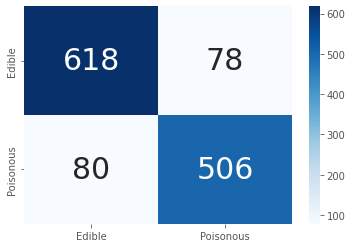

In [ ]:
cf = confusion_matrix(y_true, y_pred_total)
df_cm = pd.DataFrame(cf, index = class_names, columns = class_names)
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g', cbar=True, annot_kws={"size": 30})

In [ ]:
print(classification_report(y_true, y_pred_total, target_names=class_names))

              precision    recall  f1-score   support

      Edible       0.89      0.89      0.89       696
   Poisonous       0.87      0.86      0.86       586

    accuracy                           0.88      1282
   macro avg       0.88      0.88      0.88      1282
weighted avg       0.88      0.88      0.88      1282

